# [CVPR 2023] All are Worth Words: A ViT Backbone for Diffusion Models

**核心：一种将扩散模型与Trasnformer/ViT结合的范式，旨在取代UNet作为去噪网络**

## Architecture 

- 将time condition embedding和label condition embedding作为token加入patch token之前
- 输入image patch，输出的是对应的预测的noise patch
- 应用于密集预测任务（对每个像素点预测），**没有CLS token**用来分类

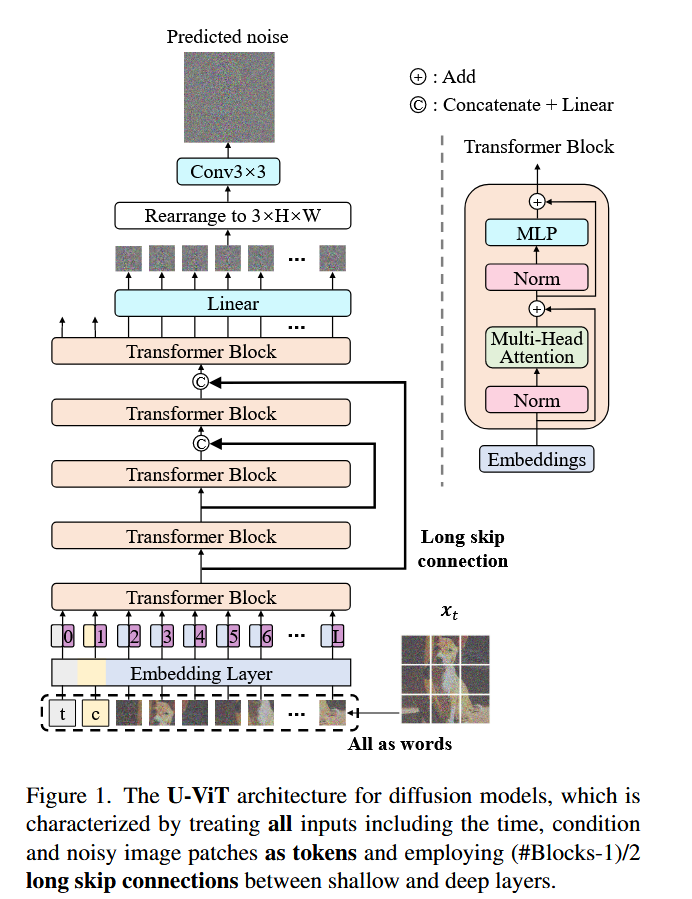


In [ ]:
# U-ViT的整体架构 
# U-ViT-main\U-ViT-main\libs\uvit.py
def forward(self, x, timesteps, y=None):
        x = self.patch_embed(x)
        B, L, D = x.shape

        time_token = self.time_embed(timestep_embedding(timesteps, self.embed_dim))
        time_token = time_token.unsqueeze(dim=1)
        x = torch.cat((time_token, x), dim=1)
        # 1.类别生成
        if y is not None:
            label_emb = self.label_emb(y)
            label_emb = label_emb.unsqueeze(dim=1)
            x = torch.cat((label_emb, x), dim=1)
        # 2.文本生成
        # context_token = self.context_embed(context)
        # x = torch.cat((time_token, context_token, x), dim=1)
        x = x + self.pos_embed

        skips = []
        for blk in self.in_blocks:
            x = blk(x)
            skips.append(x)

        x = self.mid_block(x)

        for blk in self.out_blocks:
            x = blk(x, skips.pop())

        x = self.norm(x)
        x = self.decoder_pred(x)
        assert x.size(1) == self.extras + L
        x = x[:, self.extras:, :]
        x = unpatchify(x, self.in_chans)
        x = self.final_layer(x)
        return x


### 架构设计的选择实验
设计了一系列十分充分的实验（卡是真多~~）但是关于位置编码的实验理应加上相对位置编码的一组。

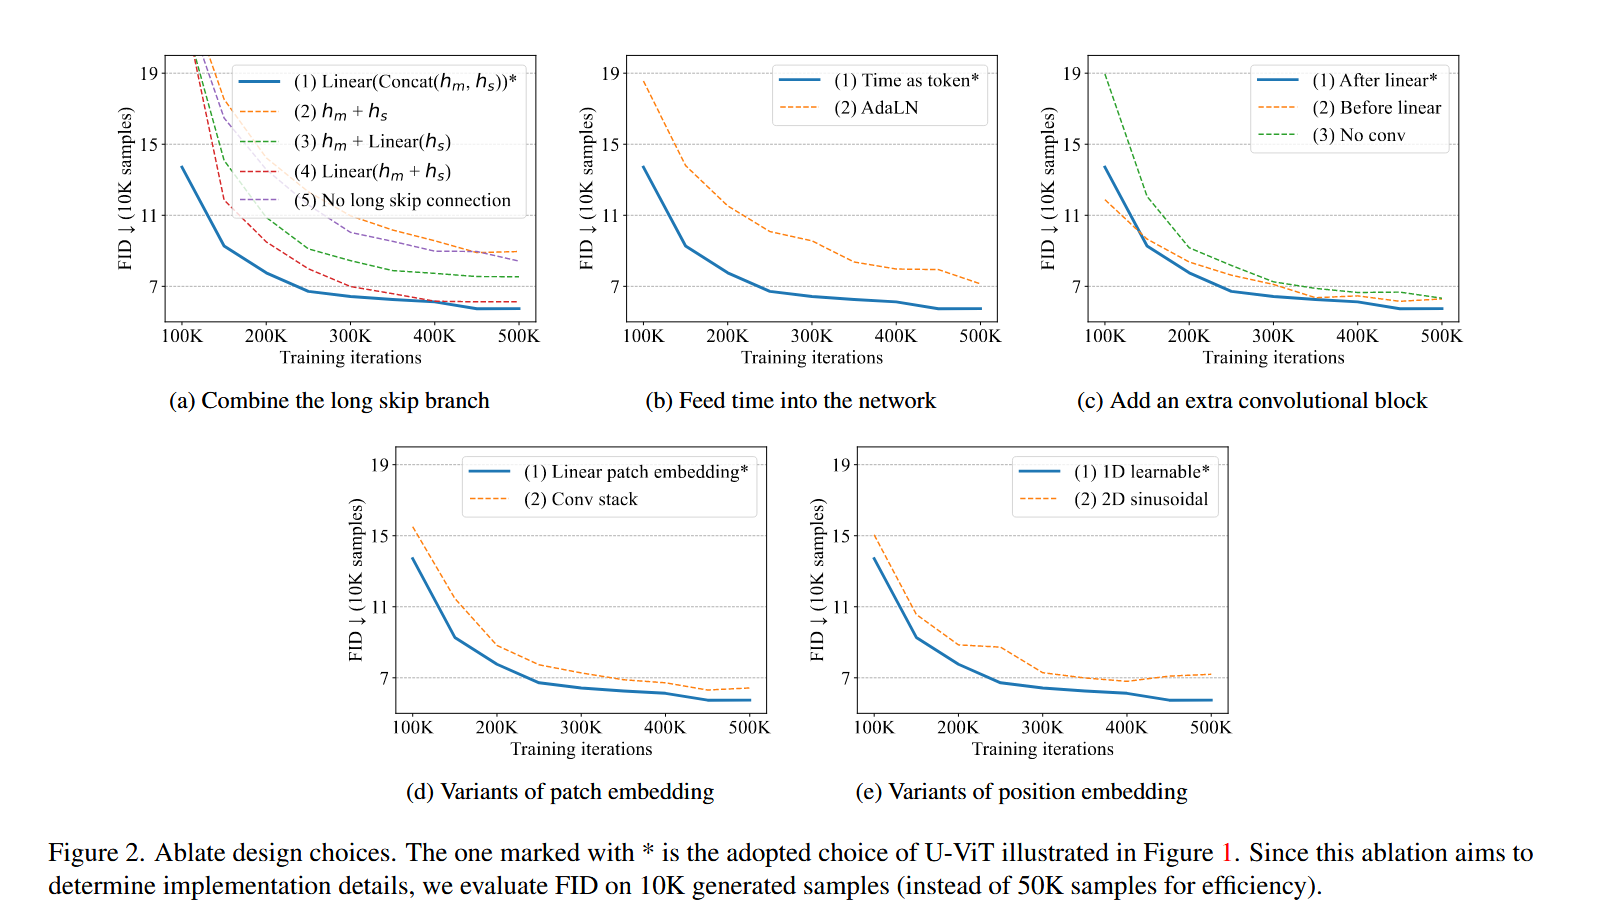

# Experiments
- Uncond：CIFAT10，CelebA
- Class Cond：ImageNet64，ImageNet256，ImageNet512
- Text Cond：MSCOCO


![屏幕截图 2025-06-30 171409.png](<attachment:屏幕截图 2025-06-30 171409.png>)
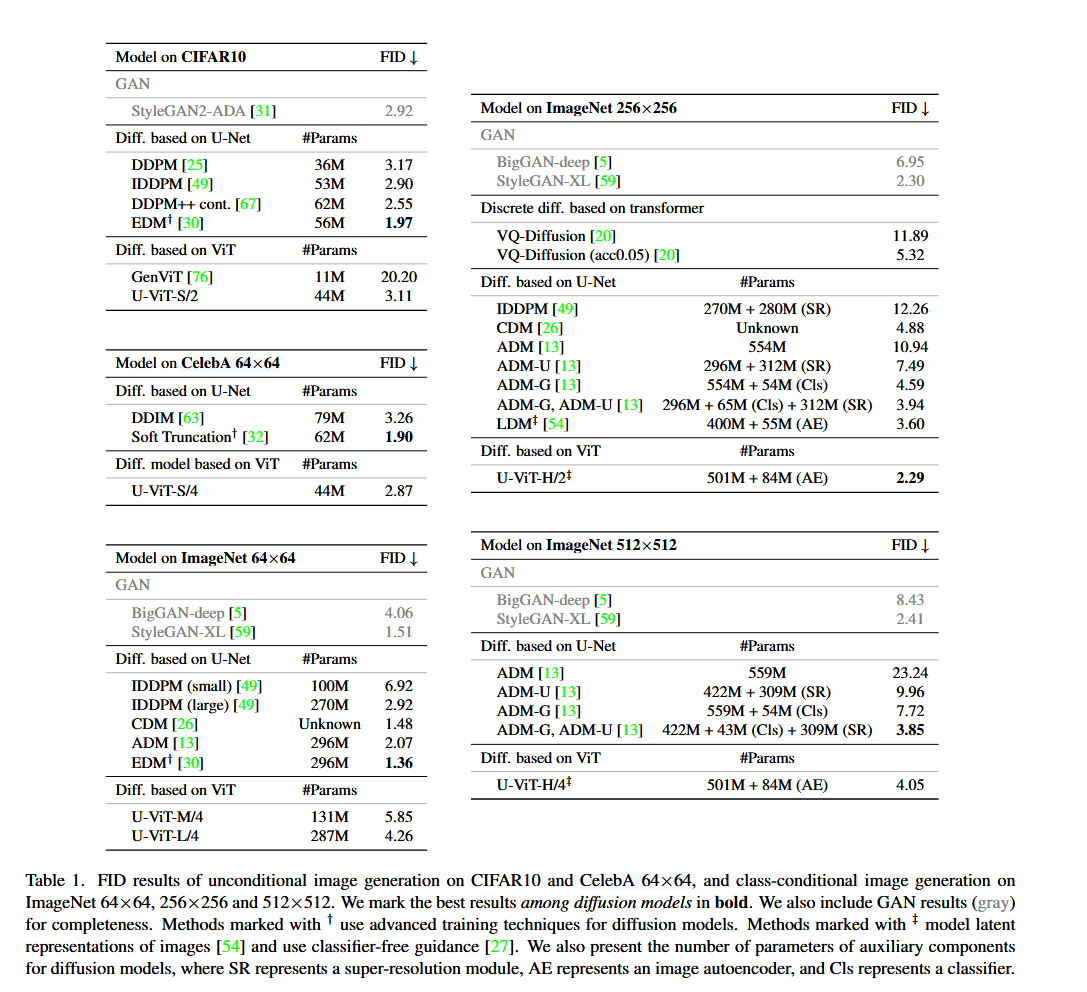

![屏幕截图 2025-06-30 171627.png](<attachment:屏幕截图 2025-06-30 171627.png>)
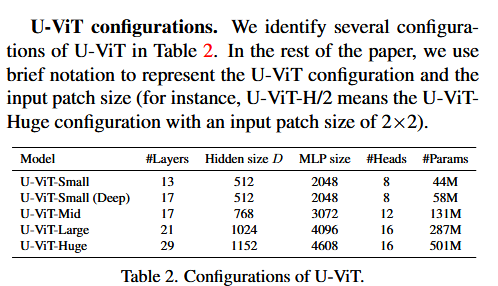

![屏幕截图 2025-06-30 173937.png](<attachment:屏幕截图 2025-06-30 173937.png>)
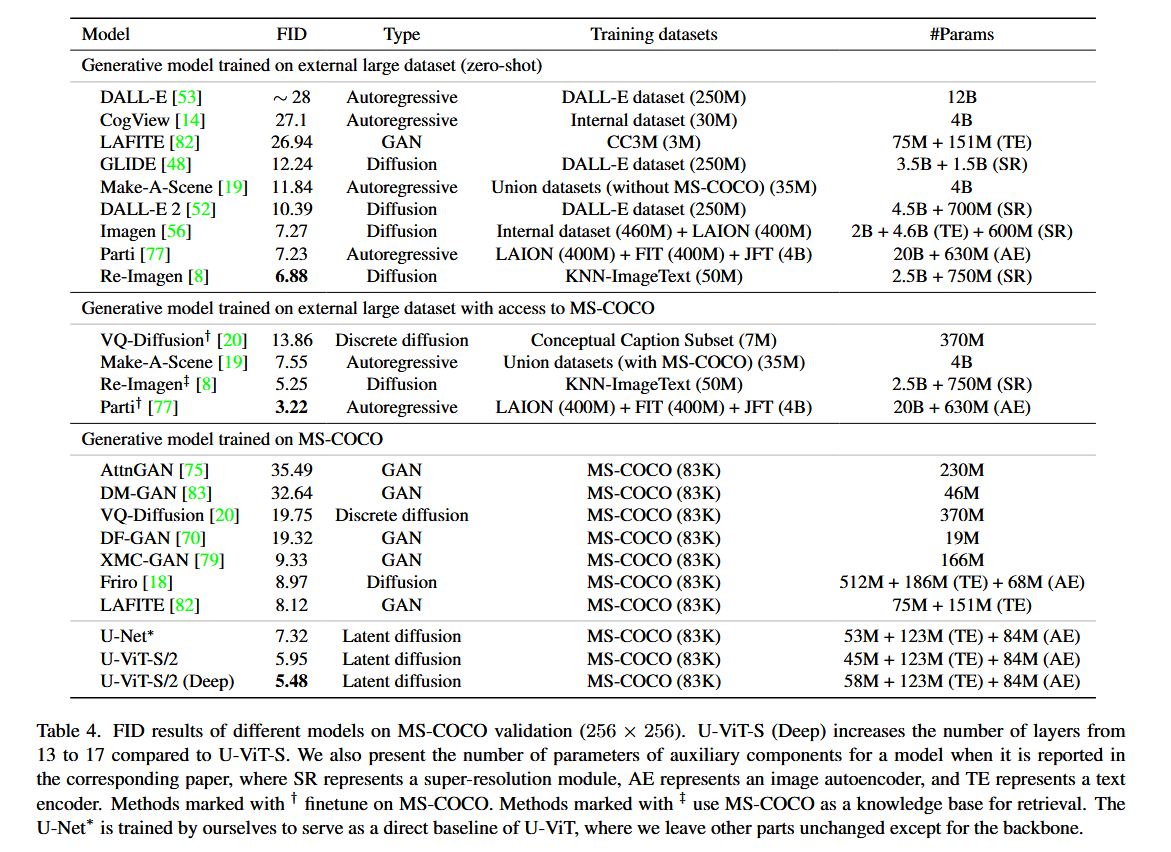

# Training
- 训练脚本
    - `train.py`：像素空间训练，在高分辨率图像上训练资源消耗大
    - `train_ldm.py`：使用预训练SDVAE将图像压缩到隐空间训练，加速训练
    - `train_ldm_discrete.py`：离散化时间步，不再使用 SDE 求解器，更加稳定
    - `train_t2i_discrete.py`：离散化时间步，接受context进行文生图，采样时使用CFG

train_ldm

In [ ]:
# 在 train 函数开头，加载 VAE
autoencoder = libs.autoencoder.get_model(config.autoencoder.pretrained_path)
autoencoder.to(device)

# 定义 VAE 的编码和解码函数
@ torch.cuda.amp.autocast()
def encode(_batch):
    return autoencoder.encode(_batch)
@ torch.cuda.amp.autocast()
def decode(_batch):
    return autoencoder.decode(_batch)

# in train_step function
def train_step(_batch):
    # ...
    # 【关键】先将图片编码到潜空间，得到 _z
    _z = autoencoder.sample(_batch) if 'feature' in config.dataset.name else encode(_batch)
    # 在潜变量 _z 上计算损失
    loss = sde.LSimple(score_model, _z, pred=config.pred)
    # ...

# in eval_step function
def sample_fn(_n_samples):
    # 【关键】初始噪声的尺寸是潜变量的尺寸 z_shape
    _z_init = torch.randn(_n_samples, *config.z_shape, device=device)
    # ...
    # 在潜空间完成采样，得到 _z
    _z = sde.euler_maruyama(...)
    # 【关键】最后用解码器将 _z 还原成图片
    return decode(_z)

train_t2i_discrete

In [ ]:
# 1. 定义离散的 beta schedule 和自定义的 Schedule 类
def stable_diffusion_beta_schedule(...): ...
class Schedule(object): ...

# 2. 定义新的、基于离散时间步的损失函数
def LSimple(x0, nnet, schedule, **kwargs):
    # schedule.sample 直接采样离散的时间步 n 和对应的噪声
    n, eps, xn = schedule.sample(x0)
    # **kwargs 会传入 context (文本编码)
    eps_pred = nnet(xn, n, **kwargs)
    return mos(eps - eps_pred)

# 3. 采样时使用 Classifier-Free Guidance (CFG)
def cfg_nnet(x, timesteps, context):
    # 有条件的预测
    _cond = nnet_ema(x, timesteps, context=context)
    # 无条件的预测 (传入空的 context)
    _empty_context = ...
    _uncond = nnet_ema(x, timesteps, context=_empty_context)
    # 【关键】将二者结合，scale 控制了文本引导的强度
    return _cond + config.sample.scale * (_cond - _uncond)

# 4. 采样时使用更先进的 DPM-Solver++
def dpm_solver_sample(...):
    # ...
    # model_fn 实际上是上面定义的 cfg_nnet
    dpm_solver = DPM_Solver(model_fn, ...)
    _z = dpm_solver.sample(...)
    return decode(_z)

# CKA 可视化

CKA (Centered Kernel Alignment) 的核心就是量化比较两个网络层输出的隐藏表示（Hidden States）有多相似

![屏幕截图 2025-06-30 180429.png](<attachment:屏幕截图 2025-06-30 180429.png>)
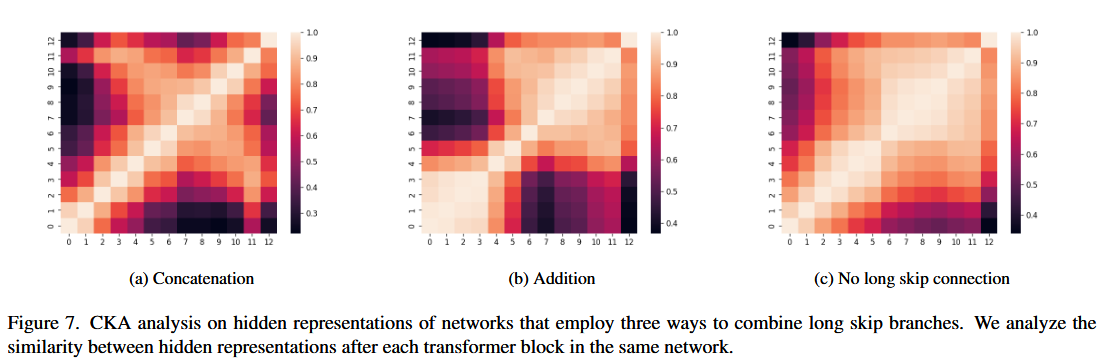

使用 "concatenation" 方式的跳跃连接，会让相邻层的表征差异变大，而 "addition" 和 "no long skip connection" 则会让相邻层功能更相似

# UViT与DiT

根据各方博客进行分析~

- UViT的作者认为：<p>
    - DiT 出色的Adaptive layer norm以及零初始化的设计能够有效提升生成质量；<p>
    - DiT 在建模特征空间表现良好，但在建模像素空间表现欠缺，可能在用扩散概率模型建模像素空间分布时long skip connection是至关重要的；<p>
    - 即使在建模特征空间上，DiT 没有long skip connection也能取得很好的效果，但long skip connection在加速收敛方面也起着关键的作用，如下图所示

![屏幕截图 2025-06-30 181436.png](<attachment:屏幕截图 2025-06-30 181436.png>)
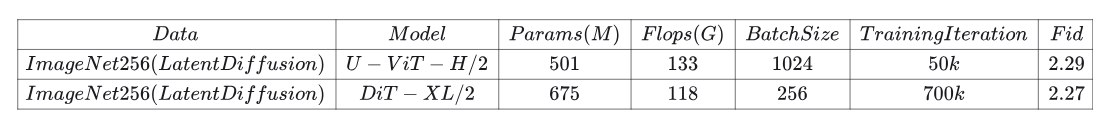

https://www.zhihu.com/question/654624362/answer/3486594121 <p>
也有用户认为：
- UViT的实验表明“将时间步作为Token输入”优于AdaLN，而DiT的结论恰好相反
- UViT似乎发现其Transformer Block的数量需要为奇数方便进行skip connection，而DiT则没有这个限制
- UViT的实验显示在输出端接入卷积层能略微提升效果

我自己认为其实核心区别就在于long skip connection这一点，加上它能够加速收敛；而AdaIn的条件注入方式也未必就比Token形式注入好很多，至少并非全面优于Token注入

![屏幕截图 2025-06-30 183826.png](<attachment:屏幕截图 2025-06-30 183826.png>)
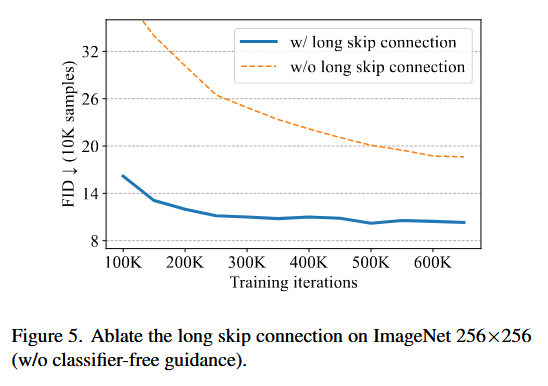

后期有一些DiT的变体参考了UViT的架构，例如Hunyuan-DiT......<p>
有时间拜读一下~

问:SD3中的MMDiT为什么以DiT为backbone，为什么不以UViT为backbone，两者差很多吗？<p>问:2024年的模型几乎将几种condition方式都探索了一遍，那么在2025那种更好有定论了吗？或者有更好的方案吗？